# SMS Spam Classification

This notebook illustrates classification of SMS as SPAM or NOT SPAM. 

### Installing Dependicies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas
import sklearn
import pickle
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

/home/purna/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/purna/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## Preprocessing and Exploring the Dataset

Importing the Dataset spam.csv

In [2]:
data = pd.read_csv('data/TRAIN_SMS.csv', encoding='latin-1')
data.head()


,Label,Message
0,ham,oh how abt 2 days before Christmas
1,info,"Welcome to OVATION HOLD R.No. 184, 114, 395, 3..."
2,info,Thank you for using your ICICI bank CREDITcard...
3,ham,schedule a meeting with the entire team in the...
4,ham,Tommy is my brother


Removing unwanted columns

In [3]:
#data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
#data = data.rename(columns={"v2" : "text", "v1":"label"})

In [4]:
data[1990:2000]

,Label,Message
1990,info,Thank you for choosing Uber for 2011-02-22 at ...
1991,info,"Hi Customer, Booking ID: W06YWI7. Seats: PLATI..."
1992,ham,meeting is at sharp 12 noon
1993,spam,Rs.423.00 was spent on ur HDFCBank CREDIT Card...
1994,ham,are we going to Jessie's party tomorrow at 6?
1995,info,"PNR:8487457773,TRAIN:1718,DOJ:2014-10-18,SL,AP..."
1996,spam,"Dear Rider, pay only ?29 on POOL rides upto 4k..."
1997,spam,Delivered: Your package withIntex SMPSIwas suc...
1998,info,The PNR for your INDIGO Flt 4J537 for BLR-BEP ...
1999,info,Maha Veer Auto Agency : Service of your car KA...


In [5]:
data['Label'].value_counts()

info    13375
ham     10000
spam     6625
Name: Label, dtype: int64

### Some Visualisations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ea319cc0>]], dtype=object)

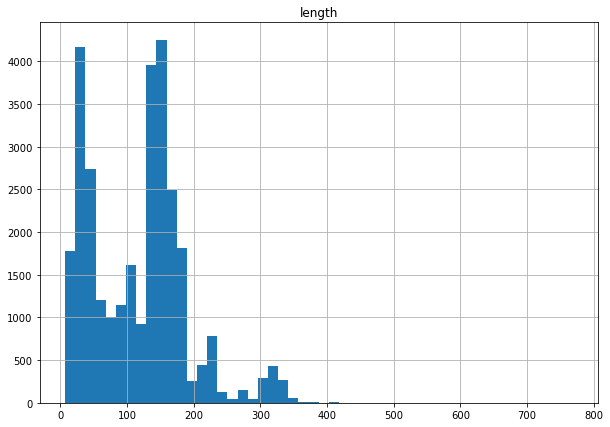

In [6]:
data['length'] = data['Message'].map(lambda x: len(x))
data.hist(column='length',bins=50, figsize=(10,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ea02cb70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb6e9e5da20>]], dtype=object)

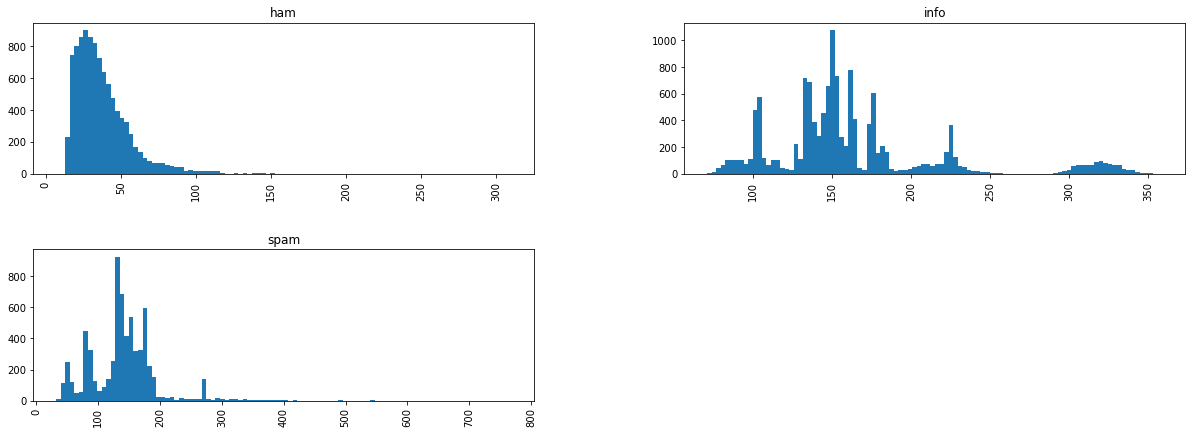

In [7]:
data.hist(column='length', by='Label', bins=100, figsize=(20,7))

In [8]:
import nltk
#nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')

### WordClouds- to see which words are common in SPAM and NOT SPAM mesaages

In [9]:
ham_words = ''
spam_words = ''
info_words = ''

In [10]:
for val in data[data['Label'] == 'spam'].Message:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        spam_words = spam_words + words + ' '
        
for val in data[data['Label'] == 'ham'].Message:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ham_words = ham_words + words + ' '

for val in data[data['Label'] == 'info'].Message:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        info_words = info_words + words + ' '

In [11]:
spam_wordcloud = WordCloud(width=500, height=300).generate(spam_words)
ham_wordcloud = WordCloud(width=500, height=300).generate(ham_words)
info_wordcloud = WordCloud(width=500, height=300).generate(info_words)

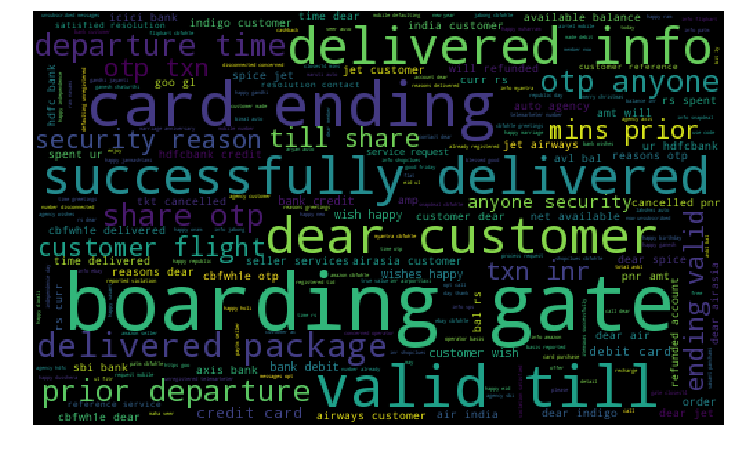

In [12]:
#Spam Word cloud
plt.figure( figsize=(10,8), facecolor='w')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

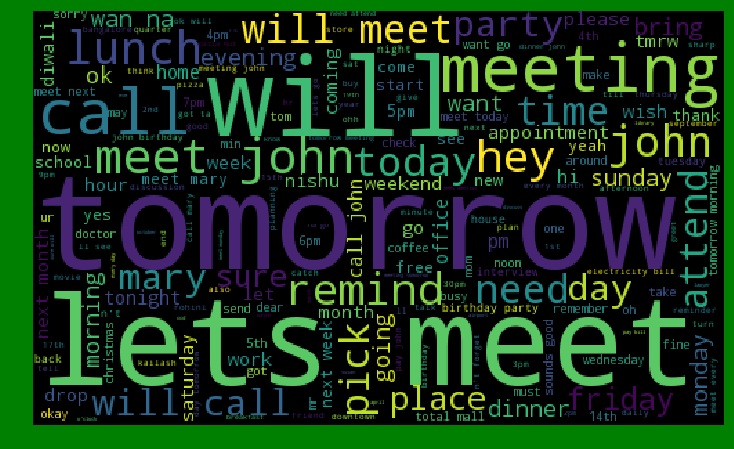

In [13]:
plt.figure( figsize=(10,8), facecolor='g')
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

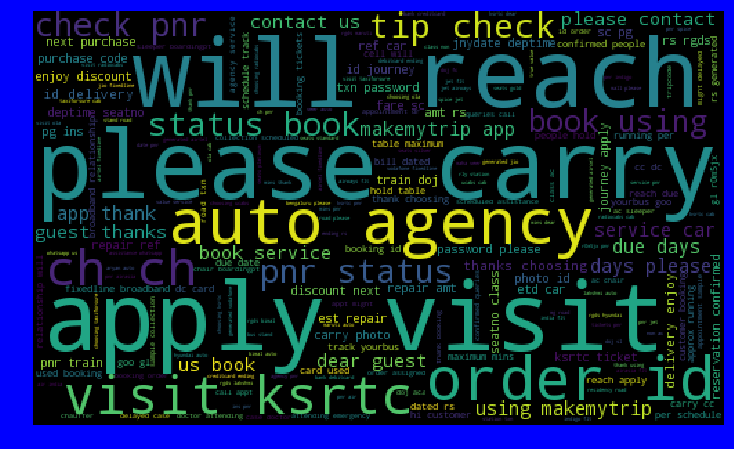

In [14]:
plt.figure( figsize=(10,8), facecolor='b')
plt.imshow(info_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [15]:
data = data.replace(['ham','spam','info'],[0, 1, 2]) 

In [16]:
data.head(10)

,Label,Message,length
0,0,oh how abt 2 days before Christmas,34
1,2,"Welcome to OVATION HOLD R.No. 184, 114, 395, 3...",95
2,2,Thank you for using your ICICI bank CREDITcard...,115
3,0,schedule a meeting with the entire team in the...,62
4,0,Tommy is my brother,19
5,1,OTP is 817453 for the txn of INR 8262.00 at SP...,174
6,0,the meeting is scheduled by john,32
7,1,"Dear customer, We wish you a Merry Christmas. ...",79
8,1,Delivered: Your package withPawzone Red 1.25 i...,126
9,2,The PNR for your Air India Flt 7I115 for PGH-B...,151


### Removing Stopwords from the messages

In [17]:
import string
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [18]:
data['Message'] = data['Message'].apply(text_process)

In [19]:
data.head()

,Label,Message,length
0,0,oh abt 2 days Christmas,34
1,2,Welcome OVATION HOLD RNo 184 114 395 378 ChIn ...,95
2,2,Thank using ICICI bank CREDITcard ending 5253 ...,115
3,0,schedule meeting entire team office tomorrow,62
4,0,Tommy brother,19


In [20]:
text = pd.DataFrame(data['Message'])
label = pd.DataFrame(data['Label'])

## Converting words to vectors

- First create a vocabulary of all words in the dataset (text messages)

- #### Vector created as follows :
 - positions with respect to highest occuring word
 - Eg : 1 at first index means first word in vocab(most frequent occuring in vocab which is 'of') occurs twice in this sentence

In [21]:
## Counting how many times a word appears in the dataset

from collections import Counter

total_counts = Counter()
for i in range(len(text)):
    for word in text.values[i][0].split(" "):
        total_counts[word] += 1
        
temp = total_counts.items()
out_tup = [i for i in temp if i[1] >= 11]
total_counts = dict(out_tup)

print("Total words in data set: ", len(total_counts))



Total words in data set:  2963


In [22]:
## Sorting in decreasing order (Word with highest frequency appears first)
vocab = sorted(total_counts, key=total_counts.get, reverse=True)
print(len(vocab))
#print(vocab[:60])

2963


In [23]:
# Mapping from words to index

vocab_size = len(vocab)
word2idx = {}
#print vocab_size
for i, word in enumerate(vocab):
    word2idx[word] = i
#print(word2idx)
import operator
sorted_x = sorted(word2idx.items(), key=operator.itemgetter(1))
print(len(vocab))
print(sorted_x)

2963
[('ID', 0), ('Dear', 1), ('PNR', 2), ('Please', 3), ('TC', 4), ('car', 5), ('Customer', 6), ('Thank', 7), ('Hi', 8), ('apply', 9), ('card', 10), ('book', 11), ('mins', 12), ('reach', 13), ('Auto', 14), ('Agency', 15), ('OTP', 16), ('choosing', 17), ('carry', 18), ('gate', 19), ('YourBus', 20), ('Rs', 21), ('ending', 22), ('confirmed', 23), ('meet', 24), ('Thanks', 25), ('call', 26), ('bank', 27), ('next', 28), ('using', 29), ('time', 30), ('KSRTC', 31), ('INR', 32), ('days', 33), ('contact', 34), ('Service', 35), ('purchase', 36), ('till', 37), ('us', 38), ('Order', 39), ('Code', 40), ('due', 41), ('Road', 42), ('visit', 43), ('successfully', 44), ('Visit', 45), ('Enjoy', 46), ('tickets', 47), ('Valid', 48), ('per', 49), ('hrs', 50), ('date', 51), ('App', 52), ('info', 53), ('status', 54), ('flight', 55), ('delivered', 56), ('share', 57), ('left', 58), ('service', 59), ('Welcome', 60), ('Check', 61), ('Bill', 62), ('discount', 63), ('package', 64), ('Delivery', 65), ('shall', 66),

In [24]:
### Text to Vector
def text_to_vector(text):
    i = 0
    word_vector = np.zeros(786)
    for word in text.split(" "):
        if word2idx.get(word) is None:
            continue
        else:
            word_vector[i] = int(word2idx[word])
            i = i+1
    return np.array(word_vector)

In [25]:
## Convert all titles to vectors
word_vectors = np.zeros((len(text), 786))

for ii, (_, text_) in enumerate(text.iterrows()):
    word_vectors[ii] = text_to_vector(text_[0])
print(word_vectors)

[[  788.   841.   132. ...,     0.     0.     0.]
 [   60.   102.  1690. ...,     0.     0.     0.]
 [    7.    29.   184. ...,     0.     0.     0.]
 ..., 
 [ 1717.    38.  2844. ...,     0.     0.     0.]
 [   74.    64.  2724. ...,     0.     0.     0.]
 [   16.    85.    32. ...,     0.     0.     0.]]


In [26]:
word_vectors.shape

(30000, 786)

## Converting words to vectors using TFIDF Vectorizer

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data['Message'])
vectors.shape

(30000, 50104)

## Choosing which algorithm we want to use a features : TFIDF or using custom vocabulary ?

In [28]:
#features = word_vectors
features = vectors

### Splitting into training and test set

In [29]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, data['Label'], test_size=0.01, random_state=111)

In [30]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(29700, 50104)
(300, 50104)
(29700,)
(300,)


## Initial Classification using XGBoost

### XGBoost using custom vocab

In [31]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'multi:softmax'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10
params['num_class'] = 3

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

XGBoostError: b'[13:26:13] src/metric/elementwise_metric.cc:28: Check failed: (preds.size()) == (info.labels.size()) label and prediction size not match, hint: use merror or mlogloss for multi-class classification'

### XGBoost using TFIDF

In [ ]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'error'
params['eta'] = 0.02
params['max_depth'] = 10

d_train = xgb.DMatrix(X_train, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=400, verbose_eval=10)

In [ ]:
from sklearn.metrics import accuracy_score

# Predict values for test set
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Apply function round() to each element in np array
# so predictions are all either 0 or 1.
npround = np.vectorize(round)
p_test_ints = npround(p_test)

# Error rate for test set
accuracy = accuracy_score(y_test, p_test_ints)
print("Test Accuracy: ", accuracy)

Test Accuracy using TFIDF Algorithm:  0.971291866029

Test Accuracy using custom vocab:     0.972488038278

## Classifying using sklearn pre built classifiers

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [48]:
svc = SVC(kernel='rbf', gamma=0.5)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.1)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='newton-cg', penalty='l2')
rfc = RandomForestClassifier(n_estimators=200, random_state=111)

In [49]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc}

In [50]:
def train(clf, features, targets):    
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))

In [51]:
pred_scores_word_vectors = []
for k,v in clfs.items():
    train(v, X_train, y_train)
    pred = predict(v, X_test)
    pred_scores_word_vectors.append((k, [sklearn.metrics.accuracy_score(y_test , pred)]))
    print(sklearn.metrics.accuracy_score(y_test , pred))

0.973333333333
0.943333333333
0.98
0.983333333333
0.973333333333
0.983333333333


## Predictions using TFIDF Vectorizer algorithm

In [52]:
predictions = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score'])
print(predictions)

        Score
SVC  0.973333
KN   0.943333
NB   0.980000
DT   0.983333
LR   0.973333
RF   0.983333


## Predictions using custom vocabulary

In [53]:
predictions_word_vectors = pd.DataFrame.from_items(pred_scores_word_vectors,orient='index', columns=['Score_'])
predictions_word_vectors

,Score_
SVC,0.973333
KN,0.943333
NB,0.980000
DT,0.983333
LR,0.973333
RF,0.983333


## Plot of scores TFIDF Vectorizer algorithm

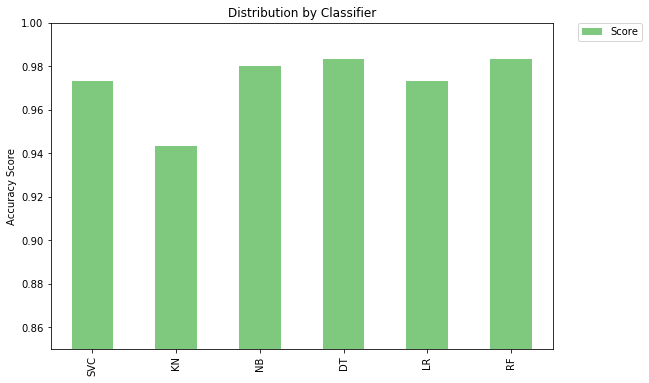

In [54]:
predictions.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Plot of scores custom vocabulary

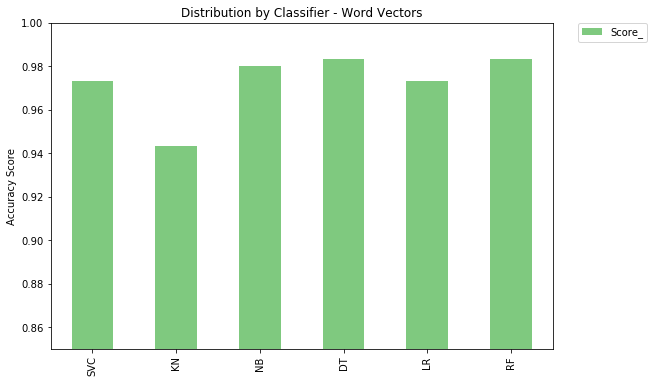

In [55]:
predictions_word_vectors.plot(kind='bar', ylim=(0.85,1.0), figsize=(9,6), align='center', colormap="Accent")
plt.xticks(np.arange(6), predictions_word_vectors.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier - Word Vectors')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [107]:
y_val = []
def find(p):
    
    if p == 1:
        print ("Message is spam")
        y_val.append('spam')
    elif p == 0:
        print ("Message is ham")
        y_val.append('ham')
    elif p == 2:
        print ("Message is info")
        y_val.append('info')
        
len(y_val)

0

In [108]:
text = ["Free tones Hope you enjoyed your new content"]
integers = vectorizer.transform(text)

In [109]:
p = mnb.predict(integers)[0]
find(p)        

Message is spam


## Saving the Best Model

In [110]:
from sklearn.externals import joblib
joblib.dump(mnb, 'best.pkl')
print ("Best Model (Naive Bayes) Saved")

Best Model (Naive Bayes) Saved


In [111]:
best = joblib.load('best.pkl')

In [112]:
best
len(text)
len(vocab)

2963

In [91]:
text1 = [data["Message"][0]]

for i in range(len(data["Message"])):
    text = [data["Message"][i]]
    integer = vectorizer.transform(text)
    p1 = best.predict(integer)[0]
    find(p1)


Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is spam
Message is ham
Message is spam
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is ham
Message is spam
Message is info
Message is spam
Message is info
Message is ham
Message is spam
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is spam
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is info
Message i

Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is spam
Message is info
Message is info
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is s

Message is ham
Message is spam
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is spam
Message is info
Message is spam
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is spam
Message is ham
Message is spam
Message is ham
Message is ham
Message is ham
Message is spam
Message is spam
Message is spam
Message is info
Message is spam
Message is info
Message is spam
Message is spam
Message is spam
Message is spam
Message is ha

Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is spam
Message is ham
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is spam
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is spam
Message is info
Message is ham
Message is ham
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Messa

Message is info
Message is spam
Message is spam
Message is spam
Message is ham
Message is ham
Message is spam
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is ham
Message is spam
Message is ham
Message is spam
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is spam
Message is ham
Message is spam
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is info
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is spam
M

Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is spam
Message is spam
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is spam
Message is info
Message is i

Message is info
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is spam
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is 

Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is spa

KeyboardInterrupt: 

## Testing our classifiers

In [ ]:
p1 = best.predict(integers)[0]
p2 = best.predict(integers)[0]
p3 = best.predict(integers)[0]
p4 = best.predict(integers)[0]

find(p1)
find(p2)
find(p3)
find(p4)

In [113]:
Val_set = pd.read_csv("data/TEST_SMS.csv" , encoding = 'latin-1')
print(Val_set["Message"].shape)
y_pred = []
for i in range(len(Val_set["Message"])):
    text = [Val_set["Message"][i]]
    integer = vectorizer.transform(text)
    p1 = best.predict(integer)[0]
    y_pred.append(p1)
    find(p1)



(7500,)
Message is ham
Message is spam
Message is ham
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message

Message is spam
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is info
Message is ham
Message is info
Message is spam
Message is spam
Message is spam
Message is info
Message is spam
Message is ham
Message is spam
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is spam
Message is spam
Message is info
Message is spam
Message is spam
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is spam
Message is ham
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is spam
Message is ham
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is i

Message is info
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is spam
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is spam
Message is spam
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is spam
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is ham
Message i

Message is info
Message is spam
Message is ham
Message is ham
Message is spam
Message is info
Message is info
Message is spam
Message is ham
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is spam
Message is spam
Message is spam
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message 

Message is spam
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is spam
Message is spam
Message is info
Message is ham
Message is spam
Message is info
Message is ham
Message is info
Message is spam
Message is ham
Message is info
Message is spam
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is spam
Message is info
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is spam
Message is ham
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is

Message is ham
Message is info
Message is spam
Message is spam
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is spam
Message is ham
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is ham
Message is spam
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is spam
Message is ham
Message is ham
Message is ham
Message is info
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Me

Message is info
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is spam
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Messag

Message is ham
Message is spam
Message is spam
Message is spam
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is spam
Message is spam
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is spam
Message is ham
Message is spam
Message is ham
Message is ham
Message is spam
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is ham
Messag

Message is info
Message is spam
Message is info
Message is spam
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is spam
Message is spam
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is spam
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is info
Message is info
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is 

Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is spam
Message is spam
Message is spam
Message is ham
Message is spam
Message is spam
Message is spam
Message is spam
Message is info
Message is info
Message is info
Message is spam
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is spam
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is ha

Message is spam
Message is spam
Message is ham
Message is ham
Message is spam
Message is spam
Message is spam
Message is spam
Message is spam
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is ham
Message is spam
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is spam
Message is ham
Message is spam
Message is spam
Message is spam
Message is spam
Message is info
Message is s

Message is info
Message is ham
Message is info
Message is info
Message is spam
Message is ham
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is ham
Message is spam
Message is spam
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is spam
Message is info
Message is info
Message is spam
Message is info
Message is spam
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is spam
Message is spam
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message i

Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is info
Message is ham
Message is ham
Message is info
Message is info
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is spam
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is spam
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is spam
Message is ham
Message is info
Message is info
Message is info
Message is ham
Message is info
Message is ham
Message is info
Message is info
Message is info
Message is spam
Message is info
Message is info
Message is spam
Message is spam
Message is h

Message is ham
Message is ham
Message is info
Message is spam
Message is spam
Message is info
Message is info
Message is info
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is ham
Message is ham
Message is spam
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is spam
Message is spam
Message is ham
Message is info
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is info
Message is ham
Message is info
Message is spam
Message is ham
Message is info
Message is ham
Message is ham
Message is ham
Message is ham
Message is ham
Message is ham
Message is spam
Message is info
Message is ham
Message is ham
Message is spam
Message is ham
Message is ham
Message is ham
Message is spam
Message is spam
Message is info
Message is ham
Message is info
Message is ham
Message is ham
Message is info
Message is spam
Message is ham
Message is spam
Message is info
Mess

In [114]:
print(len(y_val))
submission = pd.DataFrame({'RecordNo': Val_set['RecordNo'],
                          'Label':y_val[:7500]})
submission.to_csv("test_3.csv", index=False)

7501
